# **VAHA** - Visual Artwork for Human Affections

Deep Learning For Media final project

Part 2: Train selected model - vgg 16
    
Based on our experiment from part 1, vgg 16 performs best. Below we will train vgg 16 on Dataset: FER-2013, and save the model.
Dataset link: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer?select=train

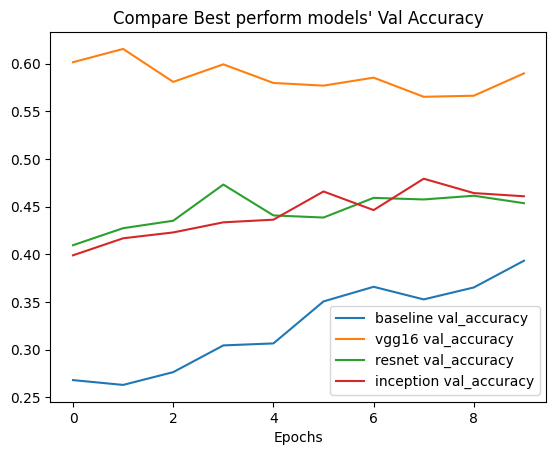

In [ ]:
import tensorflow as tf
import pathlib 
import numpy as np
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import random 
import os

tf.random.set_seed(512)

In [ ]:
# Check gpu
tf.config.list_physical_devices('GPU')

In [ ]:
# Check how many files are in our dataset 
for dirpath, dirnames, filenames in os.walk('FER-2013-dataset'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'FER-2013-dataset'.
There are 7 directories and 0 images in 'FER-2013-dataset\test'.
There are 0 directories and 958 images in 'FER-2013-dataset\test\angry'.
There are 0 directories and 111 images in 'FER-2013-dataset\test\disgusted'.
There are 0 directories and 1024 images in 'FER-2013-dataset\test\fearful'.
There are 0 directories and 1774 images in 'FER-2013-dataset\test\happy'.
There are 0 directories and 1233 images in 'FER-2013-dataset\test\neutral'.
There are 0 directories and 1247 images in 'FER-2013-dataset\test\sad'.
There are 0 directories and 831 images in 'FER-2013-dataset\test\surprised'.
There are 7 directories and 0 images in 'FER-2013-dataset\train'.
There are 0 directories and 3995 images in 'FER-2013-dataset\train\angry'.
There are 0 directories and 436 images in 'FER-2013-dataset\train\disgusted'.
There are 0 directories and 4097 images in 'FER-2013-dataset\train\fearful'.
There are 0 directories and 7215 images in 'FER-2013-d

In [ ]:
# Create training and test directory path
train_dir = 'FER-2013-dataset/train/'
test_dir = 'FER-2013-dataset/test/'
train_dir, test_dir

('FER-2013-dataset/train/', 'FER-2013-dataset/test/')

In [ ]:
# Get the class names  
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))  # create a list of class_names from the subdirectory
print(class_names)

['angry' 'disgusted' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [ ]:
# Plot out random image 
def view_random_image(target_dir, target_class):
  # Setup the target directory (well view images from here)
  target_folder = target_dir+target_class
  # Get a random image path 
  random_image = random.sample(os.listdir(target_folder), 1) #randomly get a image from the folder 
  print(random_image)

  #read in the image and plot it 
  img = mpimg.imread(target_folder + '/'+ random_image[0])
  plt.imshow(img, cmap="gray")
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}') # show the shape of the image 

  return img

['im3341.png']
Image shape: (48, 48)


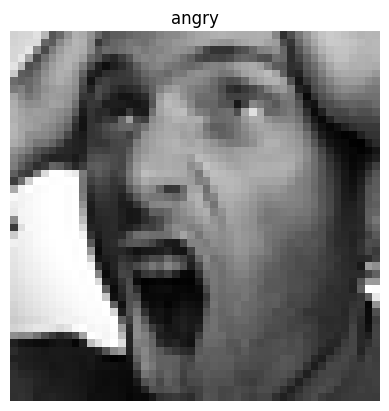

In [ ]:
# View a random image from the training dataset 
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

#### Modify dataset for VGG 16 input with data augmentation 

Based on our experiment, VGG 16 performs best with data augmentation applied. We will adapt data augmentation and train for our vgg.

In [ ]:
# Preprocessing data with keras function 
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator

# Setting up global variable for preprocessing data 
IMG_SIZE = (48, 48)
BATCH_SIZE = 32 

train_datagen_augmented = ImageDataGenerator(
                      rotation_range=20, 
                      rescale=1./255,
                      shear_range=0.2, 
                      zoom_range=0.2, 
                      width_shift_range=0.2, 
                      height_shift_range=0.2, 
                      horizontal_flip=True,
                      validation_split=0.2)

train_data_augmented_vgg = train_datagen_augmented.flow_from_directory(train_dir,
                              target_size=IMG_SIZE,
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              subset='training',
                              seed=512)

val_data_augmented_vgg = train_datagen_augmented.flow_from_directory(train_dir,
                              target_size=IMG_SIZE,
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              subset='validation',
                              seed=512)

test_data_vgg = train_datagen_augmented.flow_from_directory(test_dir,
                              target_size=IMG_SIZE,
                              color_mode='rgb',
                              class_mode='binary',
                              batch_size=BATCH_SIZE)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Unlock all layers in VGG to adapt all features with our dataset

We noticed that unlock all layers will allow VGG 16 achieve the highest accuracy on our dataset. We will train VGG with all layer set to trainable 

In [ ]:
from tensorflow.keras.applications import VGG16

VGG16_unlock = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))
VGG16_unlock.trainable = True 
VGG16_unlock.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

(None,)

#### Train VGG16 with GlobalAveragePooling2D for 20 epochs

In [ ]:
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense

vgg_unlock_model_2 = tf.keras.Sequential([
    VGG16_unlock,
    GlobalAveragePooling2D(),
    Dense(7, activation='softmax')
])

vgg_unlock_model_2.compile(loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(3e-4),
        metrics=['accuracy'])

vgg_unlock_history_2 = vgg_unlock_model_2.fit(train_data_augmented_vgg,
                                            epochs=20,
                                            steps_per_epoch=len(train_data_augmented_vgg),
                                            validation_data=val_data_augmented_vgg,
                                            validation_steps=len(val_data_augmented_vgg))

Epoch 1/20
718/718 [==============================] - 26s 31ms/step - loss: 1.7670 - accuracy: 0.2678 - val_loss: 1.6510 - val_accuracy: 0.3193
Epoch 2/20
718/718 [==============================] - 21s 30ms/step - loss: 1.5799 - accuracy: 0.3616 - val_loss: 1.4617 - val_accuracy: 0.4295
Epoch 3/20
718/718 [==============================] - 21s 30ms/step - loss: 1.3747 - accuracy: 0.4643 - val_loss: 1.2990 - val_accuracy: 0.4976
Epoch 4/20
718/718 [==============================] - 21s 29ms/step - loss: 1.2781 - accuracy: 0.5119 - val_loss: 1.2373 - val_accuracy: 0.5292
Epoch 5/20
718/718 [==============================] - 21s 30ms/step - loss: 1.2264 - accuracy: 0.5332 - val_loss: 1.2049 - val_accuracy: 0.5525
Epoch 6/20
718/718 [==============================] - 21s 30ms/step - loss: 1.1808 - accuracy: 0.5507 - val_loss: 1.1890 - val_accuracy: 0.5530
Epoch 7/20
718/718 [==============================] - 21s 30ms/step - loss: 1.1427 - accuracy: 0.5719 - val_loss: 1.1686 - val_accuracy:

In [ ]:
# Plot out loss curves 
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

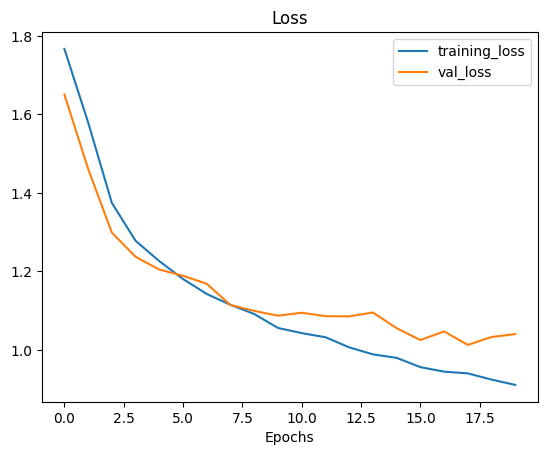

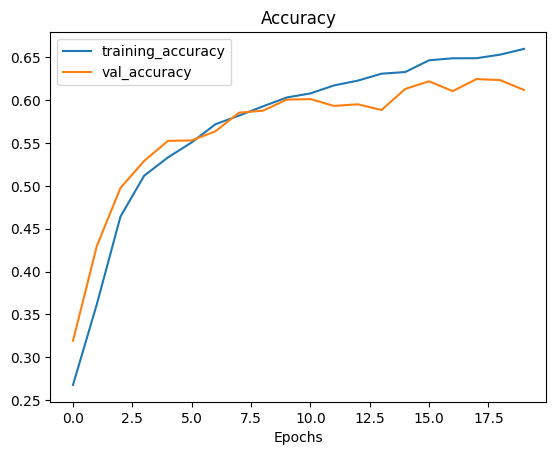

In [ ]:
plot_loss_curves(vgg_unlock_history_2)

In [ ]:
vgg_unlock_model_2.evaluate(test_data_vgg)

225/225 [==============================] - 5s 24ms/step - loss: 1.0575 - accuracy: 0.6151


[1.0574603080749512, 0.6150738596916199]

Save trained VGG model

In [ ]:
save_path='./best_vgg/'
vgg_unlock_model_2.save(save_path)

INFO:tensorflow:Assets written to: ./best_vgg/assets


INFO:tensorflow:Assets written to: ./best_vgg/assets


Test VGG by making prediction with random images from testset

In [ ]:
def load_and_prep_image(filename, img_shape=48, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (48, 48, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  img = np.repeat(img, 3, axis=-1)
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

(48, 48, 3)
1/1 [==============================] - 0s 16ms/step
(48, 48, 3)
1/1 [==============================] - 0s 16ms/step
(48, 48, 3)
1/1 [==============================] - 0s 15ms/step


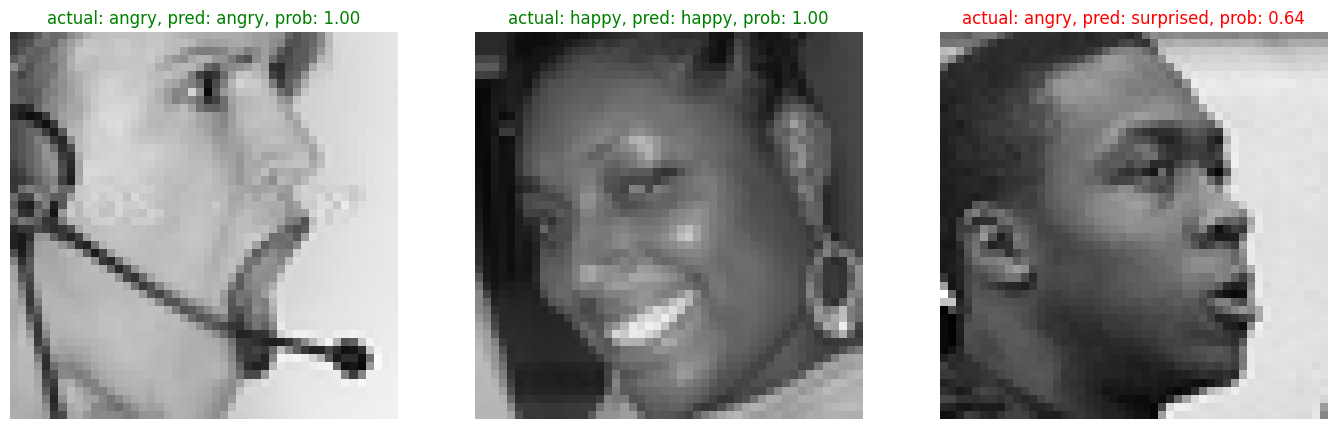

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + '/' + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  print(img.shape)
  pred_prob = vgg_unlock_model_2.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);